In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import *
from utils.manifold_utils import *
from utils.pytorch3d import *

from flow_matching.utils.manifolds import Manifold, Sphere, Euclidean
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import SoftDTW
import os
from tqdm import tqdm
from typing import Dict, Any

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
torch.manual_seed(3420934659826)

In [3]:
run_parameters =  yaml.safe_load(Path("./configs/quaternion.yaml").read_text())
run_parameters

{'train': {'lr': 0.0001,
  'epochs': 100001,
  'batch_size': 100,
  'inf_every': 4000,
  'print_every': 4000,
  'device': 'cpu',
  'inf_runs_num': 3,
  'inf_run_step': 0.05},
 'model': {'hidden_dim': 96, 'num_layers': 6, 'embed_dim': 24},
 'data': {'dim': 4,
  'manifold': 'Sphere',
  'datasets': ['Sine'],
  'horizon_size': 20,
  'inference_horizon': 10,
  'scale_factor': 1.5,
  'downsample': 5,
  'sample_points': 300,
  'mean': 0.0,
  'std': 0.5},
 'ema': {'warmup': 2000, 'update': 5, 'decay': 0.999},
 'scheduler': {'step': 10000, 'gamma': 0.5}}

In [4]:
manifold_types = {'None' : None, 'Euclidean': Euclidean(), 'Sphere':Sphere()}
val_sets= list(range(1,7))
train_sets = [0]
print(train_sets, val_sets)

[0] [1, 2, 3, 4, 5, 6]


In [5]:
manifold = manifold_types[run_parameters['data']['manifold']]
LASA_datasets = run_parameters['data']['datasets']

dataset = StatePyLASADataset(LASA_datasets,
                               train=train_sets,
                               horizon_size=run_parameters['data']['horizon_size'],
                               scaling_factor=run_parameters['data']['scale_factor'],
                               downsample = run_parameters['data']['downsample'],
                               manifold=manifold,
                               dim_to=run_parameters['data']['dim'],
                               rotate=True)

print(dataset.__len__())

train_dataset = torch.utils.data.Subset(dataset, train_sets)

test_dataset = torch.utils.data.Subset(dataset, val_sets)

train_dataloader = DataLoader(train_dataset,
                       batch_size=run_parameters['train']['batch_size'],
                       shuffle=True)

val_dataloader = DataLoader(test_dataset,
                    batch_size=run_parameters['train']['batch_size'],
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _, label = next(iter(test_dataloader))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=4,
                    shuffle=False)

print(test_dataset.__len__())
print(train_dataset.__len__())

gt_obs, gt_horizon, label = next(iter(gt_test))
print(gt_obs.shape)

7
6
1
torch.Size([4, 200, 9])


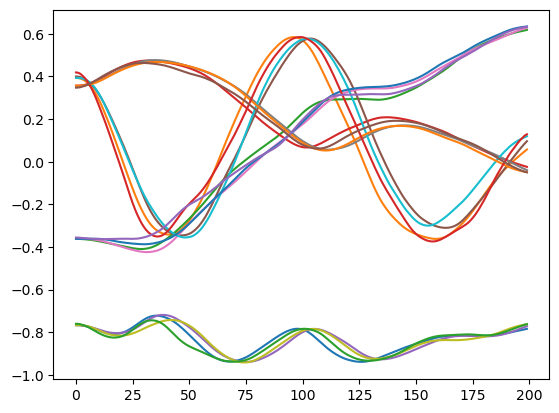

In [6]:

for i in range(4):
    plt.plot(gt_obs[i,:,:4])
    # plt.show()

In [7]:
a0 = sample_normal_source(batch_size=1200,
                        dim=3, #run_parameters['data']['dim']-1, 
                        horizon=run_parameters['data']['horizon_size'], 
                        manifold=manifold, 
                        mean=run_parameters['data']['mean'],
                        std=run_parameters['data']['std'],
                        dim_to=run_parameters['data']['dim'])

In [8]:
print((a0[:,0,]**2).sum(axis=1))

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


In [9]:
obs_train, _, _ = next(iter(train_dataloader))

In [10]:
obs_test, _, _ = next(iter(test_dataloader))

In [11]:
print(obs_train.shape)

torch.Size([1, 200, 9])


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from mpl_toolkits.mplot3d import Axes3D

# === Quaternion utilities ===
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_conjugate(q):
    q = np.array(q)
    return np.array([q[0], -q[1], -q[2], -q[3]])

def apply_quaternion(q, v):
    """Rotate 3D vector v by quaternion q."""
    q_v = np.concatenate([[0.0], v])
    return quaternion_multiply(
        quaternion_multiply(q, q_v),
        quaternion_conjugate(q)
    )[1:]  # return vector part

# === Create sample quaternion sequence ===
# Replace this with your actual data: quaternions of shape [n, 4]
n = 100
angles = np.linspace(0, 2 * np.pi, n)
quaternions = Sphere().projx(obs_test[0,:,:4])

# === Visualization ===
def plot_quaternion_rotation(i):
    q = quaternions[i]
    v0 = np.array([1, 0, 0])  # original vector
    v_rot = apply_quaternion(q, v0)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Draw original and rotated vectors
    ax.quiver(0, 0, 0, *v0, color='blue', label='Original')
    ax.quiver(0, 0, 0, *v_rot, color='red', label='Rotated')

    # Draw unit sphere for context
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:20j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="lightgray", linewidth=0.5, alpha=0.5)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f"Quaternion index: {i}")
    ax.legend()
    plt.show()

# === Interactive slider ===
interact(plot_quaternion_rotation, i=IntSlider(min=0, max=n-1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

In [13]:
print(((obs_test[0,:,:4])**2).sum(axis=1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [14]:
obs_mat = quaternion_to_matrix(obs_test[0,:,:4])